Training data set length=163
Testing data set length=51
                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  163
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12310.
Date:                Sat, 13 Jun 2020   Deviance:                       23045.
Time:                        00:28:19   Pearson chi2:                 2.26e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


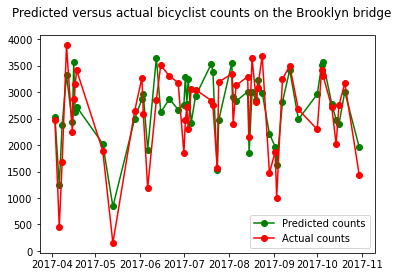

In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

#create a pandas DataFrame for the counts data set
df = pd.read_csv('https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

#add a few derived regression variables to the X matrix
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

#create the training and testing data sets
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_train['BB_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_COUNT']) / x['BB_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

#Print the regression params
print(aux_olsr_results.params)

#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

#print the training summary
print(nb2_training_results.summary())

#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted counts versus the actual counts for the test data
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

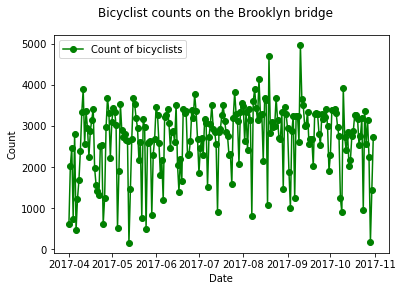

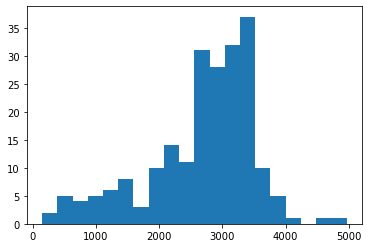

Mean=2680.04
Median=2857.0
Training data set length=170
Testing data set length=44
                            OLS Regression Results                            
Dep. Variable:               BB_COUNT   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     32.14
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           2.40e-25
Time:                        00:30:52   Log-Likelihood:                -1320.4
No. Observations:                 170   AIC:                             2655.
Df Residuals:                     163   BIC:                             2677.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

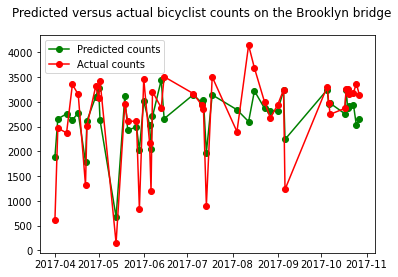

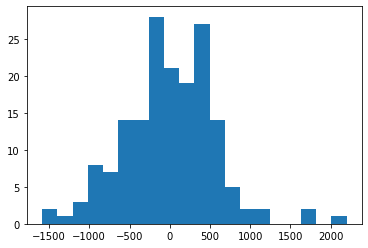

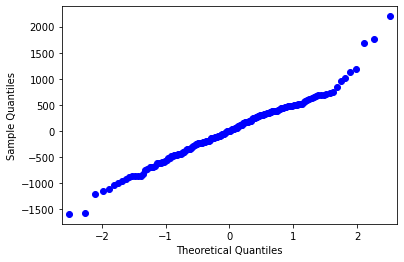

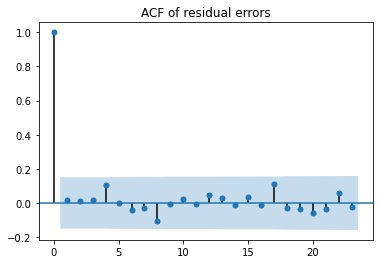

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

#load the data into a pandas data frame and plot the BB_COUNT variable
df = pd.read_csv('https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/raw/7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
fig = plt.figure()
fig.suptitle('Bicyclist counts on the Brooklyn bridge')
plt.xlabel('Date')
plt.ylabel('Count')
actual, = plt.plot(df.index, df['BB_COUNT'], 'go-', label='Count of bicyclists')
plt.legend(handles=[actual])
plt.show()

#create a histogram plot to see how normally distributed is this data set
plt.hist(df['BB_COUNT'], bins=20)
plt.show()

#print out a few descriptive stats: the mean, median, skewness, and kurtosis.
#For skewness and kurtosis, we'll run the Jarque-Bera normality test on the BB_COUNT variable
from statsmodels.stats.stattools import jarque_bera as jb
from statsmodels.stats.stattools import omni_normtest as omb
from statsmodels.compat import lzip

print('Mean='+str(round(df['BB_COUNT'].mean(), 2)))
print('Median='+str(round(df['BB_COUNT'].median(), 2)))
name = ['Jarque-Bera', 'Chi^2 two-tail probability', 'Skewness', 'Kurtosis']
test_results = jb(df['BB_COUNT'])
lzip(name, test_results)

#Try to fix the skewness by transforming the dependent variable
#Add two new columns to the data frame: a LOG(BB_COUNT) column and a  SQRT(BB_COUNT)
import numpy as np

#Add a column to the Data Frame that contains log(BB_COUNT):
df['LOG_BB_COUNT'] = np.log(df['BB_COUNT'])
#All another column containing sqrt(BB_COUNT)
df['SQRT_BB_COUNT'] = np.sqrt(df['BB_COUNT'])

#run the Jarque-Bera again on the LOG and SQRT columns to see if there is any improvement in normality
name = ['Jarque-Bera', 'Chi^2 two-tail probability', 'Skewness', 'Kurtosis']
test_results = omb(df['LOG_BB_COUNT'])
lzip(name, test_results)
test_results = omb(df['SQRT_BB_COUNT'])
lzip(name, test_results)

#revert to using the original BB_COUNT. Build, trainand test an OLSR model on the counts data

#start  with importing all the required packages
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

#add a few derived regression variables to the X matrix
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

#create the training and testing data sets
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP
expr = 'BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP'

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Configure and fit the OLSR model
olsr_results = smf.ols(expr, df_train).fit()

#Print the regression output
print(olsr_results.summary())

#generate the model's predictions on the test data
olsr_predictions = olsr_results.get_prediction(X_test)

#let's print them out
predictions_summary_frame = olsr_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted and the actual values
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#plot histogram of the residual errors
plt.hist(olsr_results.resid, bins=20)
plt.show()

#plot the Q-Q plot of the residual errors
fig = sm.qqplot(olsr_results.resid)
plt.show()

#plot the ACF plot of residual errors
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(olsr_results.resid, title='ACF of residual errors')
plt.show()

Training data set length=581
Testing data set length=150
                   Generalized Linear Model Regression Results                   
Dep. Variable:     registered_user_count   No. Observations:                  581
Model:                               GLM   Df Residuals:                      570
Model Family:                    Poisson   Df Model:                           10
Link Function:                       log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:            -1.0893e+05
Date:                   Sat, 13 Jun 2020   Deviance:                   2.1212e+05
Time:                           00:33:49   Pearson chi2:                 2.02e+05
No. Iterations:                        5                                         
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

C:\Users\Diogo\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1520: FutureWarning: Anscombe residuals currently unscaled. In a future release, they will be scaled.
  'release, they will be scaled.', category=FutureWarning)


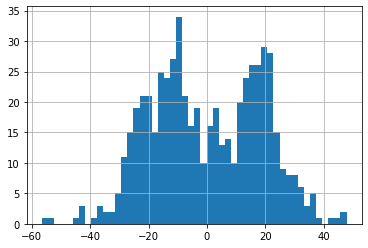

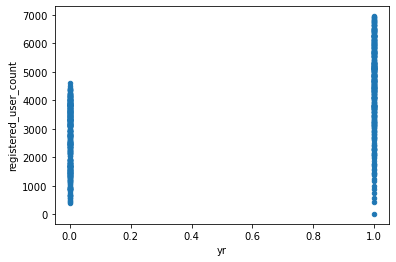

                   Generalized Linear Model Regression Results                   
Dep. Variable:     registered_user_count   No. Observations:                  581
Model:                               GLM   Df Residuals:                      569
Model Family:                    Poisson   Df Model:                           11
Link Function:                       log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -51614.
Date:                   Sat, 13 Jun 2020   Deviance:                       97478.
Time:                           00:33:49   Pearson chi2:                 8.65e+04
No. Iterations:                        5                                         
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1850 

C:\Users\Diogo\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1520: FutureWarning: Anscombe residuals currently unscaled. In a future release, they will be scaled.
  'release, they will be scaled.', category=FutureWarning)


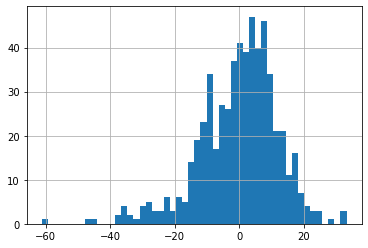

            mean    mean_se  mean_ci_lower  mean_ci_upper
10   1645.545054   4.226207    1637.282653    1653.849149
12   1720.193458   5.082484    1710.260760    1730.183842
18   1783.070212   3.871781    1775.497786    1790.674934
22   1229.237138   3.973354    1221.474124    1237.049490
23   1754.121687   4.825100    1744.690113    1763.604247
..           ...        ...            ...            ...
700  3489.867303  10.073635    3470.179088    3509.667220
701  3322.625830   8.632379    3305.749682    3339.588133
706  4390.224372   9.385125    4371.868346    4408.657468
711  4266.076730  10.221360    4246.090198    4286.157340
718  5167.550206  10.109733    5147.773434    5187.402957

[150 rows x 4 columns]


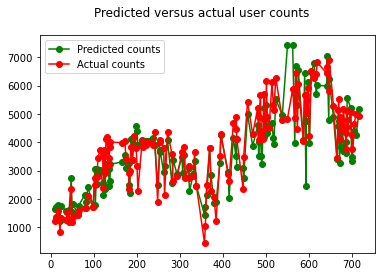

In [5]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as st
import matplotlib.pyplot as plt

#create a pandas DataFrame for the counts data set
df = pd.read_csv('https://gist.github.com/sachinsdate/413910079ab4ef4332e7a97cae55d13a/raw/8b7bfd6584ddfdedfb526cf377cee2278fb36bd0/bike_sharing_dataset_daywise.csv', header=0, parse_dates=['dteday'], infer_datetime_format=True)

#create the training and testing data sets
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

#Create the regression expression in Patsy syntax. We are saying that registered_user_count is the dependent variable and it depends on all the variables mentioned on the right side of ~\
expr = 'registered_user_count ~ season + mnth + holiday + weekday + workingday + weathersit + temp + atemp + hum + windspeed'

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#print out the Skewness and the Kurtosis of  4 residuals to see which one is the most normally distributed
raw_residual_skewness = st.robust_skewness(poisson_training_results.resid_response)[0]
pearson_residual_skewness = st.robust_skewness(poisson_training_results.resid_pearson)[0]
anscobe_residual_skewness = st.robust_skewness(poisson_training_results.resid_anscombe)[0]
deviance_residual_skewness = st.robust_skewness(poisson_training_results.resid_deviance)[0]

raw_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_response)[0]
pearson_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_pearson)[0]
anscobe_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_anscombe)[0]
deviance_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_deviance)[0]

residual_stats = [['Raw residual', raw_residual_skewness, raw_residual_kurtosis],
                  ['Pearson\'s residual', pearson_residual_skewness, pearson_residual_kurtosis],
                  ['Anscombe residual', anscobe_residual_skewness, anscobe_residual_kurtosis],
                  ['Deviance residual', deviance_residual_skewness, deviance_residual_kurtosis]
                ]

residual_stats_df = pd.DataFrame(residual_stats, columns=['Residual', 'Skewness', 'Kurtosis'])

print(residual_stats_df)

#Let's plot it's frequency distribution of the Pearson's residuals
poisson_training_results.resid_pearson.hist(bins=50)
plt.show()

#plot registered_user_count against yr
df.plot.scatter('yr', 'registered_user_count')
plt.show()

#let's add yr into the regression expression and build and train the model again
#Set up the regression expression. This time, include yr.
expr = 'registered_user_count ~ yr + season + mnth + holiday + weekday + workingday + weathersit + temp + atemp + hum + windspeed'

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#Once again, let's inspect all 4 kinds of residuals of the revised model:
deviance_residual_skewness = st.robust_skewness(poisson_training_results.resid_deviance)[0]

raw_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_response)[0]
pearson_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_pearson)[0]
anscobe_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_anscombe)[0]
deviance_residual_kurtosis = st.robust_kurtosis(poisson_training_results.resid_deviance)[0]

residual_stats = [
['Raw residual', raw_residual_skewness, raw_residual_kurtosis],['Pearson\'s residual', pearson_residual_skewness, pearson_residual_kurtosis],
['Anscombe residual', anscobe_residual_skewness, anscobe_residual_kurtosis],
['Deviance residual', deviance_residual_skewness, deviance_residual_kurtosis]
                ]

residual_stats_df = pd.DataFrame(residual_stats, columns=['Residual', 'Skewness', 'Kurtosis'])

print(residual_stats_df)

#Let's plot the frequency distribution of the Pearson's residual of the revised model
poisson_training_results.resid_pearson.hist(bins=50)
plt.show()

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['registered_user_count']

#Plot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual user counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()